# Use Hawkes processes in Cramér-Lundberg type model 

## Libraries import 


In [62]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style()

from ipywidgets import interact, widgets

from numba import njit, prange
import time

We parallelize computations thanks to $numba$ library.

## Simulations 

### Homogeneous Poisson Processes`

We simulate a HPP with rate $\lambda$ on $[0,T]$.`


In [61]:
def Simulate_HPP(lamb, T):
    n = 0
    t = [- np.log(npr.random()) / lamb]
    while t[-1] <= T:
        u = npr.random()
        w = - np.log(u) / lamb
        t.append(t[-1] + w)
    return t[:-1]

### Inhomogeneous Poisson Processes

In the case of HPP, we need a fixed rate intensity but now we want to simulate a IPP. So we vary the intensity $\lambda$ according to a deterministic function of time.

So we determine lambda_bar such as $sup_{0\leq t \leq T} \lambda(t)$. 

Inspired on Lewis and Shelder, 1979, p.7, Algorithm 1, we simulate a IPP with bounder intensity function $\lambda(t)$ on $[0,T]$. 

In [63]:
def Simulate_IPP(lamb, T, lamb_bar):
    n = 0
    m = 0
    t = []
    s = 0
    
    while s < T:
        u = npr.random()
        w = -np.log(u)/lamb_bar
        s += w
        D = npr.random()
        if D < lamb(s)/lamb_bar:
            t.append(s)
    if t[-1] < T:
        return t
    else:
        return t[:-1]

### Intensity function for Hawkes Process 

In order to simulate a Hawkes Process, we need to simulate $\lambda(t)$ as a left-contunous stochastic process given by the Stieljes integral : 
 
 $\lambda(t)$ = $\mu + \sum_{{k :t_k < t}}\alpha \exp({-\beta (t-t_k)}) $.


In [64]:
@njit
def lambda_bar(mu, alpha, beta, s, tau):
    S = mu
    for t in tau:
        S += alpha * np.exp(- beta * (s - t))
    return S

### Hawkes Processes

The simulation of a Univariate Hawkes Process is based on the exponential Kernel $\gamma(u) = \alpha \exp({-\beta (u)})$ on $[0,T]$. 

In [67]:
@njit
def Simulate_Hawkes(mu, alpha, beta, T):    
    tau = [0.0]  # Necessary to Numba
    s = 0
    while s < T:
        u = npr.random()
        lamb_bar = lambda_bar(mu, alpha, beta, s, tau[1:])  # We don't take the first 0.0
        w = -np.log(u) / lamb_bar
        s += w
        D = npr.random()
        
        if D * lamb_bar < lambda_bar(mu, alpha, beta, s, tau[1:]):  # We don't take the first 0.0
            tau.append(s)
        
    # We take off the first 0 in both cases
    if tau[-1] < T:
        return tau[1:]
    else:
        return tau[1:-1]
    
def lamb_Hawkes(t, tau, mu, alpha, beta):
    tau_inf = np.asarray(tau)[np.where(np.asarray(tau) < t)]
    return mu + sum([alpha * np.exp(- beta * (t - Tau)) for Tau in tau_inf])

## Display functions 

The first one allows to plot a Poisson Process. 

In [68]:
def plot_PP(t):
    fig, ax = plt.subplots(figsize=(18, 10))
    plt.step([0] + t, [0] + list(range(len(t))))
    plt.scatter(t,[0] * len(t), color='r')
    for h, T in enumerate(t):
        plt.plot([T, T], [0, h], '--', color="darkred")
    ax.set_xlabel("t", fontsize=20)
    ax.set_ylabel("N(t)", fontsize=20)
    plt.show()

The second one allows to plot the simulation of a Hawkes Process. 

In [70]:
def plot_Hawkes(mu, alpha, beta, T):
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(18, 12), sharex=True, gridspec_kw = {'height_ratios':[2, 1]})
    tau = Simulate_Hawkes(mu, alpha, beta, T)
    ax[0].step([0] + tau, [0] + list(range(len(tau))))
    ax[0].scatter(tau, [0] * len(tau), color='r')
    for h, Tau in enumerate(tau):
        ax[0].plot([Tau, Tau], [0, h], '--', color="darkred")
    
    tt = np.linspace(0, T, num=10000)
    lamb_to_plot = [lamb_Hawkes(t, tau, mu, alpha, beta) for t in tt]
    
    ax[1].plot(tt, lamb_to_plot)
    ax[1].scatter(tau, [0] * len(tau), color='r')
    for h, Tau in enumerate(tau):
        ax[1].plot([Tau, Tau], [0, lamb_Hawkes(Tau, tau, mu, alpha, beta)], '--', color="darkred")
    
    
    ax[1].set_xlabel("t",fontsize=20)
    ax[0].set_ylabel("N(t)",fontsize=20)
    ax[1].set_ylabel("$\lambda$(t)",fontsize=20)
    
    ax[0].set_title("Hawkes Processes, " + r"$\mu =$"  + str(mu) +  r"$, \alpha =$" + str(alpha) + r"$, \beta =$" + str(beta), fontsize=20)
    plt.show()

## Results 

We simulate a HPP with rate $3$ on $[0,15]$.

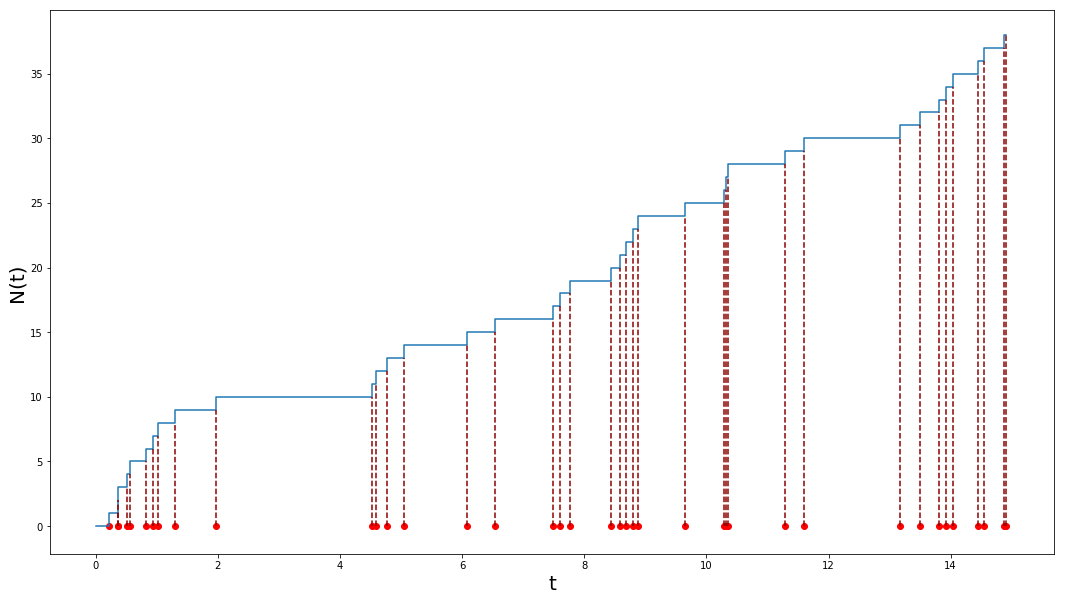

In [71]:
plot_PP(Simulate_HPP(3, 15))

We simulate a IPP with bounder intensity function $\lambda(t) = t $ on $[0,15]$. 

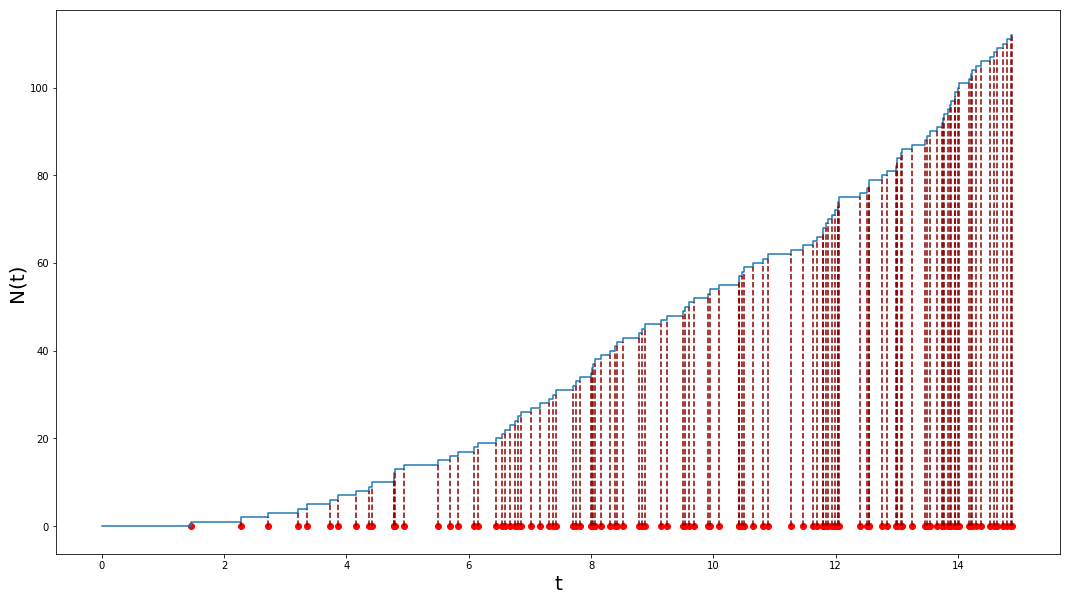

In [28]:
def lamb0(t):
    return t
plot_PP(Simulate_IPP(lamb0, 15, 15))

In [72]:
mu = 1.2
alpha = 0.6
beta = 0.8
T = 15

@interact(alpha=widgets.FloatSlider(min=0, max=3, step=0.1, value=0.6, continuous_update=False),
          beta=widgets.FloatSlider(min=0, max=3, step=0.1, value=0.8, continuous_update=False))
def test_param(alpha, beta):
    if alpha < beta:
        plot_Hawkes(mu, alpha, beta, T)
    else:
        print("Alpha must be lower than beta !")

interactive(children=(FloatSlider(value=0.6, continuous_update=False, description='alpha', max=3.0), FloatSlid…

With $\alpha = 0$, we found a Homogenous Poisson Process.

When $\alpha$ increases, the more the processes jump, the more it is self-excited. 

The more $\beta$ increases, the faster is the decrease of $\lambda$. 

## Cramer-Lundberg model with Hawkes Processes

In [76]:
@njit
def X_Hawkes(mu, sigma, alpha, beta, T):
    '''Computation of claims utile time T '''
    N = len(Simulate_Hawkes(mu, alpha, beta, T))
    X = np.exp(npr.normal(mu, sigma, N)) #logNormale
    return X

@njit(parallel=True)
def Rapport_ST(mu, sigma, alpha, beta, T, N, nb_alpha, nb_beta):
    """Computation of the ratio of the expection of S_T from Hawkes processes estimated by Monte-Carlo 
    and the expection of S_T from HPP with parameter mu"""
    range_beta = np.linspace(alpha, 3, nb_beta)
    range_alpha = np.linspace(0, beta, nb_alpha)
    S_beta = np.zeros(nb_beta)
    S_alpha = np.zeros(nb_alpha)
    for i in prange(N):
        S_beta += np.array([np.sum(X_Hawkes(mu, sigma, alpha, beta, T)) for beta in range_beta])
        S_alpha += np.array([np.sum(X_Hawkes(mu, sigma, alpha, beta, T)) for alpha in range_alpha])
    S_beta = S_beta / (T * mu * np.exp(mu + sigma ** 2 / 2)) / N
    S_alpha = S_alpha / (T * mu * np.exp(mu + sigma ** 2 / 2)) / N
    
    return range_alpha, S_alpha, range_beta, S_beta
    
def plot_rapports(range_alpha, S_alpha, range_beta, S_beta):
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(18, 15))
    
    ax[0].plot(range_beta, S_beta)
    ax[0].set_title("Relate to " + r"$\alpha = $" + str(alpha), fontsize=20)
    ax[0].set_xlabel(r"$\beta$", fontsize=20)
    ax[0].set_ylabel(r"$E[S_T^H]/E[S_T^N]$", fontsize=20)

    ax[1].plot(range_alpha, S_alpha)
    ax[1].set_title("Reltate to " + r"$\beta = $" + str(beta), fontsize=20)
    ax[1].set_xlabel(r"$\alpha$", fontsize=20)
    ax[1].set_ylabel(r"$E[S_T^H]/E[S_T^N]$", fontsize=20)
    
    plt.show()

In [77]:
mu = 1.2
sigma = 2
T = 10
alpha = 1
beta = 1
N = 15000
nb_alpha = 100
nb_beta = 100

range_alpha, S_alpha, range_beta, S_beta = Rapport_ST(mu, sigma, alpha, beta, T, N, nb_alpha, nb_beta)
plot_rapports(range_alpha, S_alpha, range_beta, S_beta)

RecursionError: Failed at nopython (convert to parfors)
maximum recursion depth exceeded in comparison

In order to see the variations of $alpha$ and $beta$ at the same time, we create a matrix. 

In [78]:
@njit(parallel=True)
def mat_rapport_esp(mu, sigma, alpha_max, beta_max, T, N, nb_alpha, nb_beta):
    """Computation of the ratio of the expection of S_T from Hawkes processes estimated by Monte-Carlo 
    and the expection of S_T from HPP with parameter mu"""
    
    range_alpha = np.linspace(0, alpha_max, nb_alpha)    
    range_beta = np.linspace(alpha_max, beta_max, nb_beta)
    result = np.zeros((nb_alpha, nb_beta))
    
    for i in prange(N):
        for ind, beta in enumerate(range_beta):
            result[:, ind] += np.array([np.sum(X_Hawkes(mu, sigma, alpha, beta, T)) for alpha in range_alpha[::-1]])
    
    result = result / N # Moyenne sur N réalisations
    result = result / (T * mu * np.exp(mu + sigma ** 2 / 2))  # Rapport des espérances
    
    return result, range_alpha, range_beta

def plot_mat_rapport(result, range_alpha, range_beta):
    fig, ax = plt.subplots(figsize=(13, 8))
    sns.heatmap(result, annot=True, cbar=True, xticklabels=np.round(range_beta, 2), yticklabels=np.round(range_alpha[::-1], 2))
    ax.set_xlabel("Values of beta")
    ax.set_ylabel("Values of alpha")
    plt.show()

In [79]:
mu = 1.2
sigma = 1
T = 15
N = 10000
nb_alpha = 10
nb_beta = 10
alpha_max = 1.5
beta_max = 3

plot_mat_rapport(*mat_rapport_esp(mu, sigma, alpha_max, beta_max, T, N, nb_alpha, nb_beta))

AssertionError: Failed at nopython (convert to parfors)


## Particular Case

In this case, we will respect the importance of a claim. Beyond a limit, we consider that the repercutions of a desaster are more important. For example, the more an accident is important, the more the number of medicals needs created are important too. 

We modelize $\lambda$ as $\mu + \sum_{{k :t_k < t}}\alpha \exp({-\beta (t-t_k)}) \mathbb{1}_{X_k > S} $ with $X_k$ the value of the claim and $S$ the limit. 

In [53]:
@njit
def lambda_bar_Seuil(mu, alpha, beta, s, tau, X, Seuil):
    S = mu
    for ind, t in enumerate(tau[1:]):  # We don't tocuh the first 0.0
        S += alpha * np.exp(- beta * (s - t)) * (X[ind + 1] >= Seuil)
    return S

@njit
def Simulate_Hawkes_Seuil(mu, sigma, alpha, beta, T, S):
    tau = [0.0]
    s = 0
    X = [0.0]
    while s < T:
        X += list(np.exp(npr.normal(mu, sigma, 1))) #logNormale
        lamb_bar = lambda_bar_Seuil(mu, alpha, beta, s, tau, X, S)
        u = npr.random()
        w = -np.log(u)/lamb_bar
        s += w
        D = npr.random()
        
        if D * lamb_bar < lambda_bar_Seuil(mu, alpha, beta, s, tau, X, S):
            tau += [s]
        else:
            del X[-1]
        
        
    if tau[-1] < T:
        return tau[1:], np.array(X[1:])
    else:
        return tau[1:-1], np.array(X[1:-1])

def lamb_Hawkes_Seuil(t, tau, mu, alpha, beta, X, S):
    tau_inf = np.asarray(tau)[np.where(np.asarray(tau) < t)]
    return mu + sum([alpha * np.exp(- beta * (t - Tau)) * (X[ind] > S) for ind, Tau in enumerate(tau_inf)])

### Evaluation of the limit 

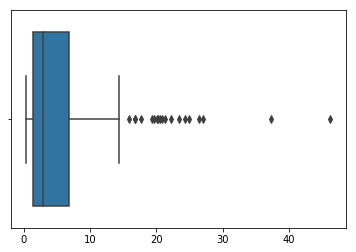

In [54]:
T = 15
X = X_Hawkes(mu, sigma, alpha, beta, T)
sns.boxplot(X)
plt.show()

In [38]:
S = np.quantile(X, 0.75)
print("3rd quartile : ", np.quantile(X, 0.75))
print("Claims maximum : ", max(X))

4.333093249606258

In [55]:
def plot_Hawkes_Seuil(mu, sigma, alpha, beta, T, S):
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(18, 12), sharex=True, gridspec_kw = {'height_ratios':[2, 1]})
    tau, X = Simulate_Hawkes_Seuil(mu, sigma, alpha, beta, T, S)
    ax[0].step([0] + tau, [0] + list(range(len(tau))))
    ax[0].scatter(tau, [0] * len(tau), color='r')
    for h, Tau in enumerate(tau):
        ax[0].plot([Tau, Tau], [0, h], '--', color="darkred")
    
    tt = np.linspace(0, T, num=10000)
    lamb_to_plot = [lamb_Hawkes_Seuil(t, tau, mu, alpha, beta, X, S) for t in tt]
    
    ax[1].plot(tt, lamb_to_plot)
    ax[1].scatter(tau, [0] * len(tau), color='r')
    for h, Tau in enumerate(tau):
        ax[1].plot([Tau, Tau], [0, lamb_Hawkes_Seuil(Tau, tau, mu, alpha, beta, X, S)], '--', color="darkred")
    
    
    ax[1].set_xlabel("t", fontsize=20)
    ax[0].set_ylabel("N(t)", fontsize=20)
    ax[1].set_ylabel("$\lambda$(t)", fontsize=20)
    
    ax[0].set_title("Hawkes Processes with limit = " + str(S) + ", " + r"$\mu =$"  + str(mu) +  r"$, \alpha =$" + str(alpha) + r"$, \beta =$" + str(beta), fontsize=20)
    plt.show()

LoweringError: Failed at nopython (nopython mode backend)
[33m[1m[33m[1mNo definition for lowering delitem(list(float64), int64) -> none
[37m[1m
File "<ipython-input-53-ce296ee653d3>", line 24:[0m
[34m[1mdef Simulate_Hawkes_Seuil(mu, sigma, alpha, beta, T, S):
    <source elided>
        else:
[31m[1m            del X[-1]
[0m            [32m[1m^[0m[0m[0m
[0m[37m[1m[1] During: lowering "del X[$const154.2]" at <ipython-input-53-ce296ee653d3> (24)[0m
-------------------------------------------------------------------------------
This should not have happened, a problem has occurred in Numba's internals.

Please report the error message and traceback, along with a minimal reproducer
at: https://github.com/numba/numba/issues/new

If you need help writing a minimal reproducer please see:
http://matthewrocklin.com/blog/work/2018/02/28/minimal-bug-reports

If more help is needed please feel free to speak to the Numba core developers
directly at: https://gitter.im/numba/numba

Thanks in advance for your help in improving Numba!


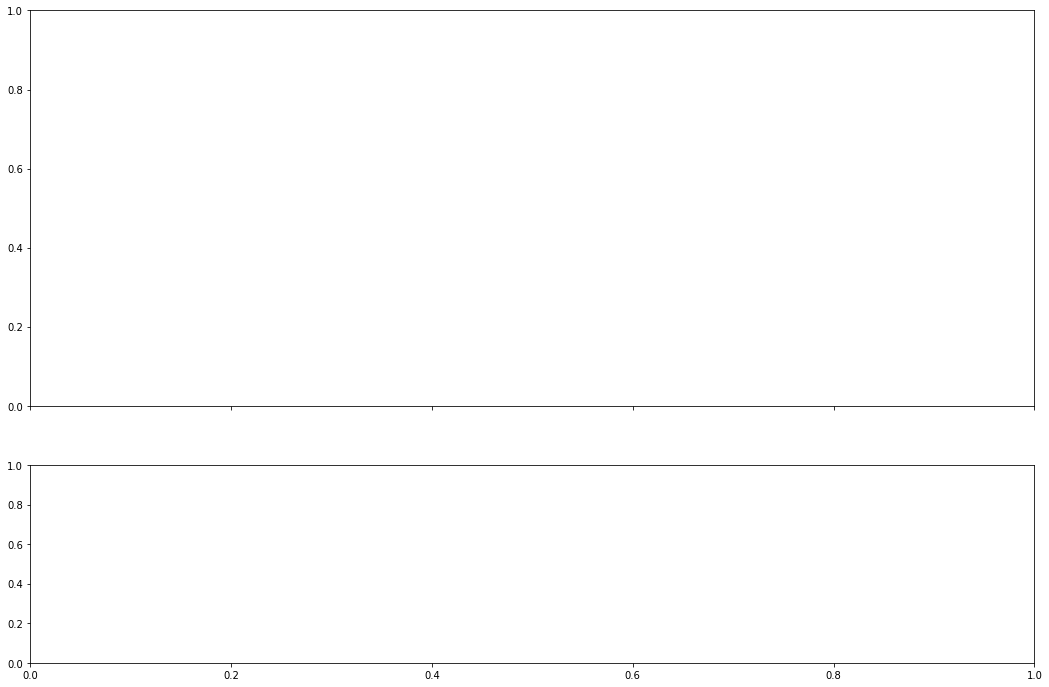

In [57]:
mu = 1.2
sigma = 1
alpha = 0.6
beta = 0.8
S = 3
plot_Hawkes_Seuil(mu, sigma, alpha, beta, T, 0)

In [58]:
@njit(parallel=True)
def Rapport_ST_Hawkes_Seuil(mu, sigma, alpha, beta, T, N, nb_seuil, Seuil_max):
    """Computation of the ratio of the expection of S_T from Hawkes processes limited and estimated by Monte-Carlo 
    and the expection of S_T from HPP estimated by Monte-Carlo"""
    
    range_seuil = np.linspace(0, Seuil_max, nb_seuil)    
    S_Hawkes = np.zeros(nb_seuil)
    S_Hawkes_seuil = np.zeros(nb_seuil)
    
    for i in prange(N):
        S_Hawkes += np.array(np.sum(X_Hawkes(mu, sigma, alpha, beta, T)))
        S_Hawkes_seuil += np.array([np.sum(Simulate_Hawkes_Seuil(mu, sigma, alpha, beta, T, seuil)[1]) for seuil in range_seuil])
        
    S_seuil = S_Hawkes_seuil / S_Hawkes
    return range_seuil, S_seuil

In [59]:
 def plot_rapport_hawkes_seuil(range_seuil, S_seuil):
    fig, ax = plt.subplots(figsize=(18, 15))
    
    ax.plot(range_seuil, S_seuil)
    ax.set_title("Ratio between Hawkes_seuil et Hawkes", fontsize=20)
    ax.set_xlabel("Limite", fontsize=20)
    ax.set_ylabel(r"$E[S_T^{H\_seuil}]/E[S_T^H]$", fontsize=20)
    plt.show()

In [80]:
mu = 1.2
sigma = 1
alpha = 1
beta = 1.5
T = 15
N = 15000
nb_seuil = 100
Seuil_max = 15

range_seuil, S_seuil = Rapport_ST_Hawkes_Seuil(mu, sigma, alpha, beta, T, N, nb_seuil, Seuil_max)

TypingError: Failed at nopython (nopython frontend)
Internal error at <numba.typeinfer.CallConstraint object at 0x1a1c1d0630>:
--%<----------------------------------------------------------------------------
Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/numba/errors.py", line 491, in new_error_context
    yield
  File "/anaconda3/lib/python3.6/site-packages/numba/lowering.py", line 216, in lower_block
    self.lower_inst(inst)
  File "/anaconda3/lib/python3.6/site-packages/numba/lowering.py", line 331, in lower_inst
    impl = self.context.get_function('delitem', signature)
  File "/anaconda3/lib/python3.6/site-packages/numba/targets/base.py", line 505, in get_function
    return self.get_function(fn, sig, _firstcall=False)
  File "/anaconda3/lib/python3.6/site-packages/numba/targets/base.py", line 507, in get_function
    raise NotImplementedError("No definition for lowering %s%s" % (key, sig))
NotImplementedError: No definition for lowering delitem(list(float64), int64) -> none

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/numba/typeinfer.py", line 138, in propagate
    constraint(typeinfer)
  File "/anaconda3/lib/python3.6/site-packages/numba/typeinfer.py", line 421, in __call__
    self.resolve(typeinfer, typevars, fnty)
  File "/anaconda3/lib/python3.6/site-packages/numba/typeinfer.py", line 447, in resolve
    sig = typeinfer.resolve_call(fnty, pos_args, kw_args, literals=literals)
  File "/anaconda3/lib/python3.6/site-packages/numba/typeinfer.py", line 1161, in resolve_call
    literals=literals)
  File "/anaconda3/lib/python3.6/site-packages/numba/typing/context.py", line 204, in resolve_function_type
    return func.get_call_type_with_literals(self, args, kws, literals)
  File "/anaconda3/lib/python3.6/site-packages/numba/types/abstract.py", line 266, in get_call_type_with_literals
    return self.get_call_type(context, args, kws)
  File "/anaconda3/lib/python3.6/site-packages/numba/types/functions.py", line 253, in get_call_type
    template, pysig, args, kws = self.dispatcher.get_call_template(args, kws)
  File "/anaconda3/lib/python3.6/site-packages/numba/dispatcher.py", line 273, in get_call_template
    self.compile(tuple(args))
  File "/anaconda3/lib/python3.6/site-packages/numba/dispatcher.py", line 618, in compile
    cres = self._compiler.compile(args, return_type)
  File "/anaconda3/lib/python3.6/site-packages/numba/dispatcher.py", line 83, in compile
    pipeline_class=self.pipeline_class)
  File "/anaconda3/lib/python3.6/site-packages/numba/compiler.py", line 871, in compile_extra
    return pipeline.compile_extra(func)
  File "/anaconda3/lib/python3.6/site-packages/numba/compiler.py", line 365, in compile_extra
    return self._compile_bytecode()
  File "/anaconda3/lib/python3.6/site-packages/numba/compiler.py", line 802, in _compile_bytecode
    return self._compile_core()
  File "/anaconda3/lib/python3.6/site-packages/numba/compiler.py", line 789, in _compile_core
    res = pm.run(self.status)
  File "/anaconda3/lib/python3.6/site-packages/numba/compiler.py", line 251, in run
    raise patched_exception
  File "/anaconda3/lib/python3.6/site-packages/numba/compiler.py", line 243, in run
    stage()
  File "/anaconda3/lib/python3.6/site-packages/numba/compiler.py", line 676, in stage_nopython_backend
    self._backend(lowerfn, objectmode=False)
  File "/anaconda3/lib/python3.6/site-packages/numba/compiler.py", line 626, in _backend
    lowered = lowerfn()
  File "/anaconda3/lib/python3.6/site-packages/numba/compiler.py", line 613, in backend_nopython_mode
    self.flags)
  File "/anaconda3/lib/python3.6/site-packages/numba/compiler.py", line 990, in native_lowering_stage
    lower.lower()
  File "/anaconda3/lib/python3.6/site-packages/numba/lowering.py", line 135, in lower
    self.lower_normal_function(self.fndesc)
  File "/anaconda3/lib/python3.6/site-packages/numba/lowering.py", line 176, in lower_normal_function
    entry_block_tail = self.lower_function_body()
  File "/anaconda3/lib/python3.6/site-packages/numba/lowering.py", line 201, in lower_function_body
    self.lower_block(block)
  File "/anaconda3/lib/python3.6/site-packages/numba/lowering.py", line 216, in lower_block
    self.lower_inst(inst)
  File "/anaconda3/lib/python3.6/contextlib.py", line 99, in __exit__
    self.gen.throw(type, value, traceback)
  File "/anaconda3/lib/python3.6/site-packages/numba/errors.py", line 499, in new_error_context
    six.reraise(type(newerr), newerr, tb)
  File "/anaconda3/lib/python3.6/site-packages/numba/six.py", line 659, in reraise
    raise value
numba.errors.LoweringError: [33m[1m[33m[1mFailed at nopython (nopython mode backend)
[33m[1m[33m[1mNo definition for lowering delitem(list(float64), int64) -> none
[37m[1m
File "<ipython-input-53-ce296ee653d3>", line 24:[0m
[34m[1mdef Simulate_Hawkes_Seuil(mu, sigma, alpha, beta, T, S):
    <source elided>
        else:
[31m[1m            del X[-1]
[0m            [32m[1m^[0m[0m[0m
[0m[37m[1m[1] During: lowering "del X[$const154.2]" at <ipython-input-53-ce296ee653d3> (24)[0m
[0m[37m[1m[2] During: resolving callee type: type(CPUDispatcher(<function Simulate_Hawkes_Seuil at 0x1a1c17cf28>))[0m
[0m[37m[1m[3] During: typing of call at <ipython-input-58-709fd83d150c> (12)
[0m
--%<----------------------------------------------------------------------------

[37m[1m
File "<ipython-input-58-709fd83d150c>", line 12:[0m
[34m[1mdef Rapport_ST_Hawkes_Seuil(mu, sigma, alpha, beta, T, N, nb_seuil, Seuil_max):
    <source elided>
        S_Hawkes += np.array(np.sum(X_Hawkes(mu, sigma, alpha, beta, T)))
[31m[1m        S_Hawkes_seuil += np.array([np.sum(Simulate_Hawkes_Seuil(mu, sigma, alpha, beta, T, seuil)[1]) for seuil in range_seuil])
[0m        [32m[1m^[0m[0m

This is not usually a problem with Numba itself but instead often caused by
the use of unsupported features or an issue in resolving types.

To see Python/NumPy features supported by the latest release of Numba visit:
http://numba.pydata.org/numba-doc/dev/reference/pysupported.html
and
http://numba.pydata.org/numba-doc/dev/reference/numpysupported.html

For more information about typing errors and how to debug them visit:
http://numba.pydata.org/numba-doc/latest/user/troubleshoot.html#my-code-doesn-t-compile

If you think your code should work with Numba, please report the error message
and traceback, along with a minimal reproducer at:
https://github.com/numba/numba/issues/new


In [81]:
plot_rapport_hawkes_seuil(range_seuil, S_seuil)

NameError: name 'range_seuil' is not defined

In [82]:
S_seuil

NameError: name 'S_seuil' is not defined